In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
# from tensorflow.keras.models import clone_model

### Specifying data directory and epochs

In [2]:
data_dir = Path("./datasets/captcha_images_v2/")
data_dir2 = Path("./datasets/dataset/")
#data_dir3 = Path("./datasets/captcha_breaker")

model_dir = Path("base_model/saved_model")

d1_epochs = 100 # Change from 30
d2_epochs = 100 # Changed from 20
#d3_epochs = 20

# Something about CTC? 

In [3]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

# Class structure for handling the datasets

In [4]:
class DataSetHandler():
    def __init__(self,  data_dir,  img_size = (200, 50)):
        pass
        
    def init_calculations(self):
        pass
        
    def print_basics(self):
        pass
    
    # def split_data(images, labels, train_size=0.9, shuffle=True):
    def split_data(self, train_size=0.9, shuffle=True):
        pass

    def encode_single_sample(self, img_path, label):
        pass

    def process_dataset(self, invert_color = False):
        pass

    def plot_examples(self):
        pass
        
    def build_model(self):
        pass
    
    def train_model(self, epochs = 10, early_stopping_patience = 10):
        pass
        
    def make_predictions(self):
        pass


# Dataset 1

In [5]:
def init(self, data_dir,  img_size = (200, 50), file_name_excluder = ""):
    self.img_width = img_size[0]
    self.img_height = img_size[1]
    self.data_dir = data_dir;
    
    self.invert_color = False
    self.batch_size = 16
    self.downsample_factor = 4
    self.init_calculations(file_name_excluder)

# explain yada yada
def init_calculations(self, file_name_excluder):
    
    self.images = sorted(list(map(str, list(self.data_dir.glob("*.png")))))
    self.labels = [img.split(os.path.sep)[-1].split(file_name_excluder + ".png")[0] for img in self.images]
    
    self.max_length = max([len(label) for label in self.labels])
    
    characters = set(char for label in self.labels for char in label)
    self.characters = sorted(list(characters))

    self.char_to_num = layers.StringLookup(
        vocabulary=list(self.characters), mask_token=None
    )
        
    # Mapping integers back to original characters
    self.num_to_char = layers.StringLookup(
        vocabulary=self.char_to_num.get_vocabulary(), mask_token=None, invert=True
    )

DataSetHandler.__init__ = init
DataSetHandler.init_calculations = init_calculations

data1 = DataSetHandler(data_dir = data_dir)

In [6]:

# explain
def print_basics(self):
    print("Number of images found: ", len(self.images))
    print("Number of labels found: ", len(self.labels))
    print("Number of unique characters: ", len(self.characters))
    print("Characters present: ", self.characters)    
    
DataSetHandler.print_basics = print_basics

data1.print_basics()

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


## Splitting data

In [ ]:
'''def split_data(self, train_size=0.7, validation_size=0.2, shuffle=True):
    # 1. Get the total size of the dataset
    images = np.array(self.images)
    labels = np.array(self.labels)
    size = len(self.images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training and validation samples
    train_samples = int(size * train_size)
    validation_samples = int(size * validation_size)
    # 4. Split data into training, validation, and test sets
    self.x_train, self.y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    self.x_valid, self.y_valid = images[indices[train_samples:(train_samples + validation_samples)]], labels[indices[train_samples:(train_samples + validation_samples)]]
    self.x_test, self.y_test = images[indices[(train_samples + validation_samples):]], labels[indices[(train_samples + validation_samples):]]
    return self.x_train, self.x_valid, self.x_test, self.y_train, self.y_valid, self.y_test

DataSetHandler.split_data = split_data

data1.split_data();'''

Alternative splitting of data:

In [7]:
def split_data(self, train_size=0.7, test_size=0.15, validation_size=0.15, shuffle=True):
    if train_size + test_size + validation_size != 1.0:
        raise ValueError("Sum of train_size, test_size, and validation_size should be equal to 1.0")

    # Shuffle the data if required
    indices = np.arange(len(self.images))
    if shuffle:
        np.random.shuffle(indices)

    # Split indices for train, validation, and test
    train_end = int(len(indices) * train_size)
    test_end = train_end + int(len(indices) * test_size)

    train_indices = indices[:train_end]
    test_indices = indices[train_end:test_end]
    validation_indices = indices[test_end:]

    # Split the data
    self.x_train, self.y_train = np.array(self.images)[train_indices], np.array(self.labels)[train_indices]
    self.x_test, self.y_test = np.array(self.images)[test_indices], np.array(self.labels)[test_indices]
    self.x_valid, self.y_valid = np.array(self.images)[validation_indices], np.array(self.labels)[validation_indices]

    return self.x_train, self.x_valid, self.x_test, self.y_train, self.y_valid, self.y_test

DataSetHandler.split_data = split_data

data1.split_data();

In [8]:
# Function to print the sizes of the datasets
def print_dataset_sizes(handler):
    print("Training Set Size:", len(handler.x_train))
    print("Validation Set Size:", len(handler.x_valid))
    print("Test Set Size:", len(handler.x_test))
    print("Total Size:", len(handler.x_train) + len(handler.x_valid) + len(handler.x_test))

# Assuming data1 is an instance of DataSetHandler
# and you've chosen either Option 1 or Option 2 for split_data
data1.split_data()  # Split the data using the chosen method
print_dataset_sizes(data1)  # Print the sizes of each dataset

Training Set Size: 728
Validation Set Size: 156
Test Set Size: 156
Total Size: 1040


## Data preprocessing

In [9]:
def encode_single_sample(self, img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [self.img_height, self.img_width])
    
    if (self.invert_color):
        # Inverting color
        img = 1- img
    
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = self.char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

DataSetHandler.encode_single_sample = encode_single_sample

In [10]:
def process_dataset(self, invert_color = False):
    self.invert_color = invert_color
    train_dataset = tf.data.Dataset.from_tensor_slices((self.x_train, self.y_train))
    self.train_dataset = (
        train_dataset.map(
            # self.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
            self.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(self.batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    validation_dataset = tf.data.Dataset.from_tensor_slices((self.x_valid, self.y_valid))
    self.validation_dataset = (
        validation_dataset.map(
            self.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(self.batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    
    test_dataset = tf.data.Dataset.from_tensor_slices((self.x_test, self.y_test))
    self.test_dataset = (
        test_dataset.map(
            self.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(self.batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    
    return (self.train_dataset, self.validation_dataset, self.test_dataset)

DataSetHandler.process_dataset = process_dataset

data1.process_dataset();

## plotting examples

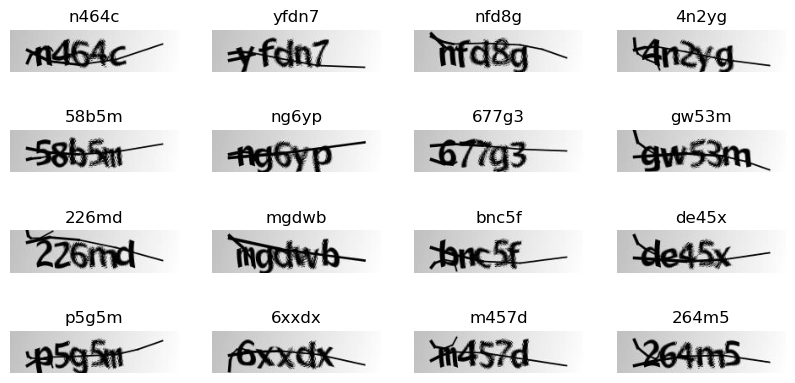

In [11]:
def plot_examples(self):
    _, ax = plt.subplots(4, 4, figsize=(10, 5))
    for batch in self.train_dataset.take(1):
        images = batch["image"]
        labels = batch["label"]
        for i in range(16):
            img = (images[i] * 255).numpy().astype("uint8")
            label = tf.strings.reduce_join(self.num_to_char(labels[i])).numpy().decode("utf-8")
            ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
            ax[i // 4, i % 4].set_title(label)
            ax[i // 4, i % 4].axis("off")
    plt.show()
    
DataSetHandler.plot_examples = plot_examples

data1.plot_examples()

## Defining a base model for the first dataset

In [12]:
def base_model_1(dataset_handler):
    # Inputs to the model
    input_img = layers.Input(
        shape=(dataset_handler.img_width, dataset_handler.img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((dataset_handler.img_width // 4), (dataset_handler.img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25), name = "bidirectional1")(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25, name = "bidirectional2"))(x)

    # Output layer
    x = layers.Dense(
        len(dataset_handler.char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
        # 50, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    dataset_handler.model = model
    return model

In [13]:
# data1.build_model = base_model_1
# model1 = data1.build_model(data1);
model1 = base_model_1(data1)
model1.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

## training model

In [14]:
def train_model(self, epochs = 10, early_stopping_patience = 10, model = None):
    # epochs = 10
    # early_stopping_patience = 10
    # Add early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
    )

    # Allowing to change on a model not defined for the dataset
    if (model):
        model_to_fit = model
    else: 
        model_to_fit = self.model
        
    
    # Train the model
    self.history = model_to_fit.fit(
        self.train_dataset,
        validation_data=self.validation_dataset,
        epochs=epochs,
        callbacks=[early_stopping],
    )

DataSetHandler.train_model = train_model

data1.train_model(epochs = d1_epochs)
# data1.train_model(epochs = 30)

Epoch 1/100
46/46 [==============================] - 10s 117ms/step - loss: 21.9429 - val_loss: 16.3449
Epoch 2/100
46/46 [==============================] - 4s 92ms/step - loss: 16.3536 - val_loss: 16.2918
Epoch 3/100
46/46 [==============================] - 4s 95ms/step - loss: 16.3341 - val_loss: 16.2907
Epoch 4/100
46/46 [==============================] - 4s 96ms/step - loss: 16.3227 - val_loss: 16.2889
Epoch 5/100
46/46 [==============================] - 4s 93ms/step - loss: 16.3181 - val_loss: 16.2862
Epoch 6/100
46/46 [==============================] - 4s 90ms/step - loss: 16.3060 - val_loss: 16.2658
Epoch 7/100
46/46 [==============================] - 4s 90ms/step - loss: 16.2856 - val_loss: 16.2546
Epoch 8/100
46/46 [==============================] - 4s 93ms/step - loss: 16.2293 - val_loss: 16.1629
Epoch 9/100
46/46 [==============================] - 4s 91ms/step - loss: 15.9738 - val_loss: 15.7144
Epoch 10/100
46/46 [==============================] - 4s 91ms/step - loss: 14.88

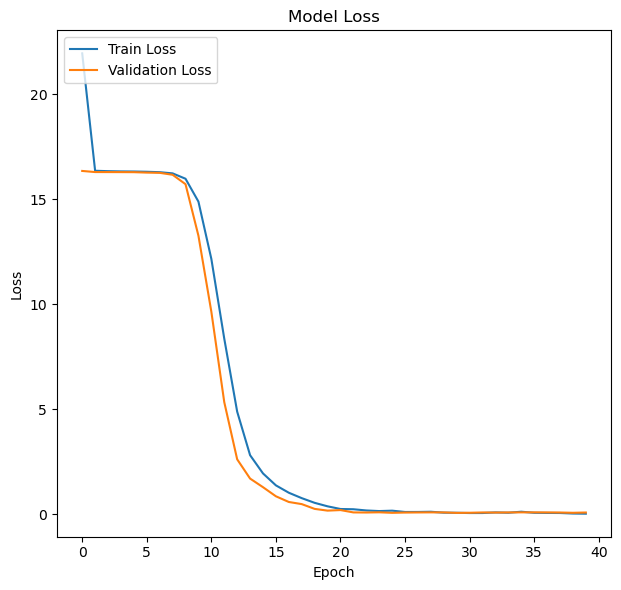

In [15]:
def plot_training_history(self):
    history = self.history.history

    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # If accuracy metrics are available, plot them
    if 'accuracy' in history and 'val_accuracy' in history:
        plt.subplot(1, 2, 2)
        plt.plot(history['accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

DataSetHandler.plot_training_history = plot_training_history
data1.plot_training_history()

## Making predictions

1/1 [==============================] - 1s 806ms/step


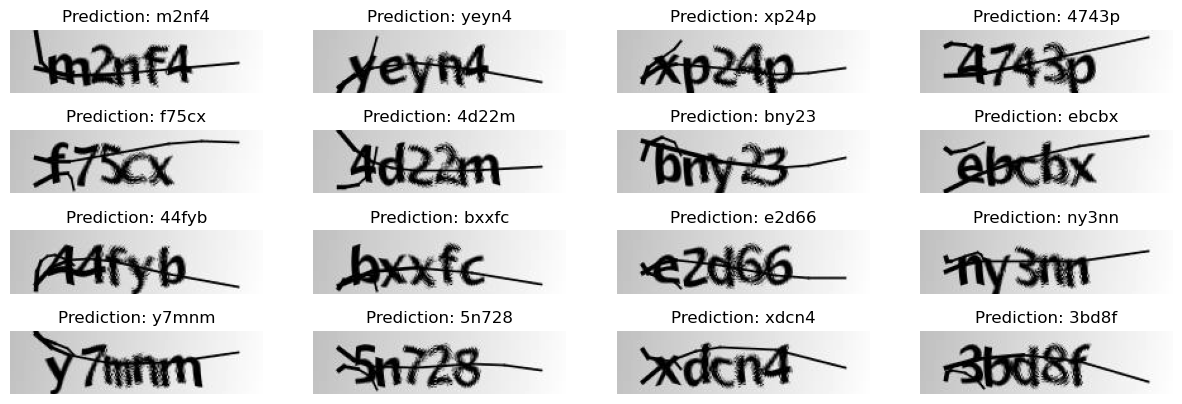

In [16]:
def make_predictions(self, model = None):
    
    if (model == None):
        _model = self.model
    else: 
        _model = model;
    # Get the prediction model by extracting layers till the output layer
    prediction_model = keras.models.Model(
        _model.get_layer(name="image").input, _model.get_layer(name="dense2").output
        # _model.get_layer(name="image").input, _model.get_layer(name="ctc_loss").output
    )
    # prediction_model.summary()

    # A utility function to decode the output of the network
    def decode_batch_predictions(pred):
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        
        # Use greedy search. For complex tasks, you can use beam search
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :self.max_length
        ]
        # Iterate over the results and get back the text
        output_text = []
        for res in results:
            res = tf.strings.reduce_join(self.num_to_char(res)).numpy().decode("utf-8")
            output_text.append(res)
        return output_text


    #  Let's check results on some validation samples
    for batch in self.test_dataset.take(1):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        orig_texts = []
        for label in batch_labels:
            label = tf.strings.reduce_join(self.num_to_char(label)).numpy().decode("utf-8")
            orig_texts.append(label)

        _, ax = plt.subplots(4, 4, figsize=(15, 5))
        for i in range(len(pred_texts)):
            img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
            img = img.T
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
    plt.show()
    
DataSetHandler.make_predictions = make_predictions

data1.make_predictions()

Precision, recall and f1 scores:

In [17]:
from sklearn.metrics import classification_report

In [18]:
def evaluate_precision_recall_f1(self):
    y_true = []
    y_pred = []

    # Utility function to decode predictions
    def decode_batch_predictions(pred):
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :self.max_length]
        output_text = []
        for res in results:
            res = tf.strings.reduce_join(self.num_to_char(res)).numpy().decode("utf-8")
            output_text.append(res)
        return output_text

    # Create a prediction model
    prediction_model = keras.models.Model(
        self.model.get_layer(name="image").input, 
        self.model.get_layer(name="dense2").output
    )

    # Iterate over the test dataset
    for batch in self.test_dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(len(pred_texts)):
            y_pred.extend(pred_texts[i])
            truth = tf.strings.reduce_join(self.num_to_char(batch_labels[i])).numpy().decode("utf-8")
            y_true.extend(truth)

    # Flatten the lists
    y_true = [char for label in y_true for char in label]
    y_pred = [char for label in y_pred for char in label]

    # Calculate and print the classification report
    print(classification_report(y_true, y_pred, labels=self.characters))

DataSetHandler.evaluate_precision_recall_f1 = evaluate_precision_recall_f1

# Example usage
data1.evaluate_precision_recall_f1()

1/1 [==============================] - 0s 30ms/step
              precision    recall  f1-score   support

           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        40
           4       1.00      1.00      1.00        40
           5       1.00      1.00      1.00        43
           6       1.00      1.00      1.00        34
           7       1.00      1.00      1.00        30
           8       1.00      1.00      1.00        44
           b       1.00      1.00      1.00        45
           c       0.98      0.98      0.98        47
           d       1.00      1.00      1.00        41
           e       0.97      0.97      0.97        35
           f       1.00      1.00      1.00        41
           g       1.00      1.00      1.00        41
           m       1.00      1.00      1.00        45
           n       1.00      1.00      1.00        73
           p       1.00      1.00      1.00        36
           w       1.00      

The function below (evaluate_character_occurrence_accuracy) evaluates the entire test dataset, giving a more accurate representation of how well the model performs on new, unseen data. It checks how many times the model predicted an occuring character, disregarding position.

In [19]:
def evaluate_image_prediction_accuracy(self):
    correct_image_predictions = 0
    total_image_predictions = 0

    # A utility function to decode the output of the network
    def decode_batch_predictions(pred):
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :self.max_length]
        output_text = []
        for res in results:
            res = tf.strings.reduce_join(self.num_to_char(res)).numpy().decode("utf-8")
            output_text.append(res)
        return output_text

    # Create a prediction model similar to the one in make_predictions
    prediction_model = keras.models.Model(
        self.model.get_layer(name="image").input, 
        self.model.get_layer(name="dense2").output
    )

    # Iterate over the test dataset
    for batch in self.test_dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        # Predict and decode
        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        # Compare predictions with actual labels
        for i in range(len(pred_texts)):
            pred = pred_texts[i]
            truth = tf.strings.reduce_join(self.num_to_char(batch_labels[i])).numpy().decode("utf-8")

            # Update image prediction accuracy
            if pred == truth:
                correct_image_predictions += 1
            total_image_predictions += 1

    # Calculate image prediction accuracy
    image_prediction_accuracy = correct_image_predictions / total_image_predictions if total_image_predictions > 0 else 0

    return total_image_predictions, correct_image_predictions, image_prediction_accuracy

DataSetHandler.evaluate_image_prediction_accuracy = evaluate_image_prediction_accuracy

# Example usage
total_images, correct_images, img_accuracy = data1.evaluate_image_prediction_accuracy()
print(f"Total images: {total_images}")
print(f"Correct predictions: {correct_images}")
print(f"Image Prediction Accuracy: {img_accuracy:.4f}")

1/1 [==============================] - 0s 31ms/step
Total images: 156
Correct predictions: 154
Image Prediction Accuracy: 0.9872


The function below (plot_character_preformance) visually represent the performance of the OCR model for each character. if plot_relative is true, it plots the relative performance as percentages, if false, it plots the absolute performance as counts.

1/1 [==============================] - 0s 29ms/step


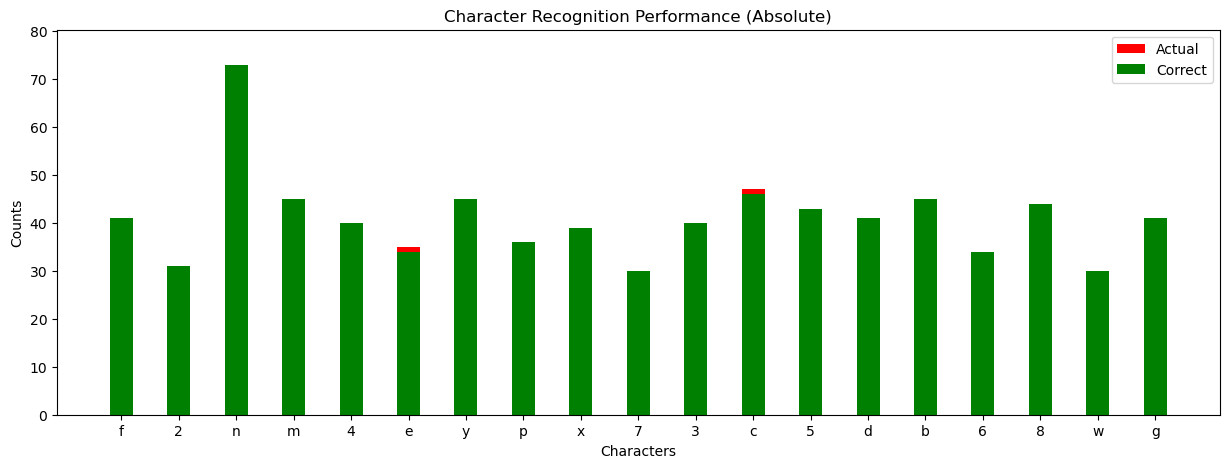

1/1 [==============================] - 0s 29ms/step


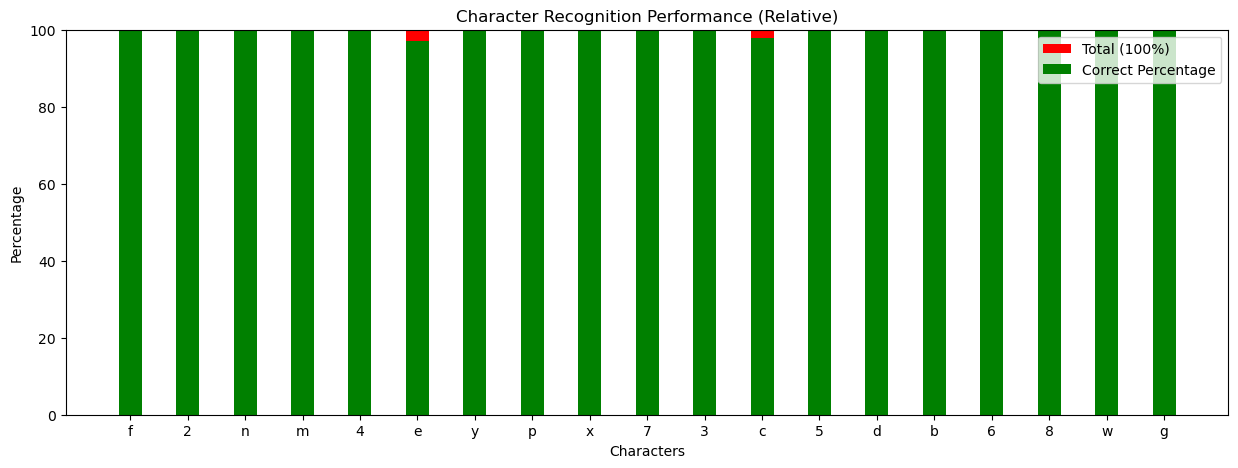

In [20]:
def plot_character_performance(self, plot_relative=False):
    character_counts = {}
    correct_character_counts = {}
    
        # A utility function to decode the output of the network
    def decode_batch_predictions(pred):
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :self.max_length]
        output_text = []
        for res in results:
            res = tf.strings.reduce_join(self.num_to_char(res)).numpy().decode("utf-8")
            output_text.append(res)
        return output_text

    def update_counts(pred, truth):
        for char in set(truth):
            character_counts[char] = character_counts.get(char, 0) + truth.count(char)
            correct_character_counts[char] = correct_character_counts.get(char, 0) + min(pred.count(char), truth.count(char))

    # Similar to the previous function, create prediction model and decode predictions
    prediction_model = keras.models.Model(
        self.model.get_layer(name="image").input, 
        self.model.get_layer(name="dense2").output
    )

    for batch in self.test_dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(len(pred_texts)):
            pred = pred_texts[i]
            truth = tf.strings.reduce_join(self.num_to_char(batch_labels[i])).numpy().decode("utf-8")
            update_counts(pred, truth)

    # Plotting
    characters = list(character_counts.keys())
    actual_counts = [character_counts[char] for char in characters]
    correct_counts = [correct_character_counts[char] for char in characters]

    x = range(len(characters))
    plt.figure(figsize=(15, 5))

    if plot_relative:
        # Calculate relative performance (percentage)
        accuracies = [100 * (correct / actual) if actual > 0 else 0 for correct, actual in zip(correct_counts, actual_counts)]
        plt.bar(x, [100] * len(characters), width=0.4, color='red', label='Total (100%)', align='center')
        plt.bar(x, accuracies, width=0.4, color='green', label='Correct Percentage', align='center')
        plt.ylabel('Percentage')
    else:
        # Plot absolute performance
        plt.bar(x, actual_counts, width=0.4, color='red', label='Actual', align='center')
        plt.bar(x, correct_counts, width=0.4, color='green', label='Correct', align='center')
        plt.ylabel('Counts')

    plt.xlabel('Characters')
    plt.xticks(x, characters)
    plt.ylim(0, 100 if plot_relative else max(actual_counts) * 1.1)  # Adjust y-axis limit
    plt.legend()
    plt.title('Character Recognition Performance (Relative)' if plot_relative else 'Character Recognition Performance (Absolute)')
    plt.show()

DataSetHandler.plot_character_performance = plot_character_performance

# Example usage for absolute performance
data1.plot_character_performance(plot_relative=False)

# Example usage for relative performance
data1.plot_character_performance(plot_relative=True)

In [21]:
def count_characters_in_training(self):
    character_counts = {}

    # Iterate through all labels in the training dataset
    for label in self.y_train:
        # Assuming labels are stored as strings; otherwise, decode or convert them as needed
        for char in label:
            if char not in character_counts:
                character_counts[char] = 0
            character_counts[char] += 1

    # Print the character counts
    print("Characters frequency in training:")
    for char, count in character_counts.items():
        print(f"'{char}' occurred {count} times")

    #return character_counts

DataSetHandler.count_characters_in_training = count_characters_in_training
data1.count_characters_in_training()

Characters frequency in training:
'n' occurred 368 times
'4' occurred 207 times
'6' occurred 183 times
'c' occurred 174 times
'y' occurred 163 times
'f' occurred 197 times
'd' occurred 170 times
'7' occurred 186 times
'8' occurred 181 times
'g' occurred 191 times
'2' occurred 198 times
'5' occurred 188 times
'b' occurred 171 times
'm' occurred 184 times
'p' occurred 169 times
'3' occurred 190 times
'w' occurred 170 times
'e' occurred 161 times
'x' occurred 189 times


# saving model

In [22]:

model1.save(model_dir) 
plot_model(model1, to_file = "base_model/model_structure/base_model.png", dpi=80, show_shapes  = True, show_layer_names = True )


INFO:tensorflow:Assets written to: base_model\saved_model\assets


INFO:tensorflow:Assets written to: base_model\saved_model\assets


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Loading model

In [23]:

loaded_model = tf.keras.models.load_model(model_dir)

In [24]:
loaded_base_model = keras.models.Model(
    loaded_model.get_layer(name="image").input, loaded_model.get_layer(name="dense2").output
)
loaded_base_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            4921

# **Second dataset**

## process data and show example

Number of images found:  3016
Number of labels found:  3016
Number of unique characters:  51
Characters present:  ['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'h', 'j', 'k', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


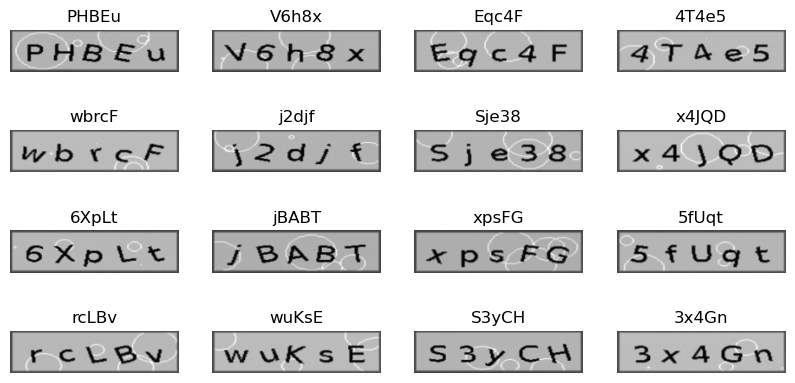

In [25]:
data2 = DataSetHandler(data_dir2)
data2.print_basics()
data2.split_data();
data2.process_dataset(invert_color = True);
data2.plot_examples()

In [33]:
print_dataset_sizes(data2)

Training Set Size: 2111
Validation Set Size: 453
Test Set Size: 452
Total Size: 3016


##  Building and training model with the same architecture as the base model

In [26]:
first_d2 = base_model_1(data2)
data2.model.summary()
data2.train_model(model = first_d2, epochs = d2_epochs)

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

132/132 [==============================] - 14s 106ms/step - loss: 2.6729 - val_loss: 5.0727
Epoch 46/100
132/132 [==============================] - 14s 107ms/step - loss: 2.5348 - val_loss: 4.9235
Epoch 47/100
132/132 [==============================] - 14s 106ms/step - loss: 2.4157 - val_loss: 4.9655
Epoch 48/100
132/132 [==============================] - 14s 107ms/step - loss: 2.2391 - val_loss: 4.9581
Epoch 49/100
132/132 [==============================] - 14s 106ms/step - loss: 2.1289 - val_loss: 4.8710
Epoch 50/100
132/132 [==============================] - 14s 105ms/step - loss: 1.9820 - val_loss: 4.8048
Epoch 51/100
132/132 [==============================] - 14s 105ms/step - loss: 1.9571 - val_loss: 4.6871
Epoch 52/100
132/132 [==============================] - 14s 107ms/step - loss: 1.8750 - val_loss: 4.6948
Epoch 53/100
132/132 [==============================] - 14s 107ms/step - loss: 1.7501 - val_loss: 4.7318
Epoch 54/100
132/132 [==============================] - 14s 107ms/st

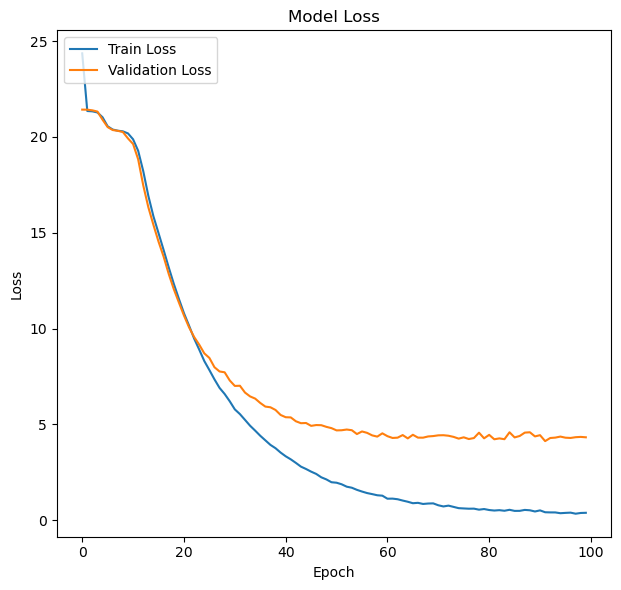

In [27]:
data2.plot_training_history()

1/1 [==============================] - 1s 875ms/step


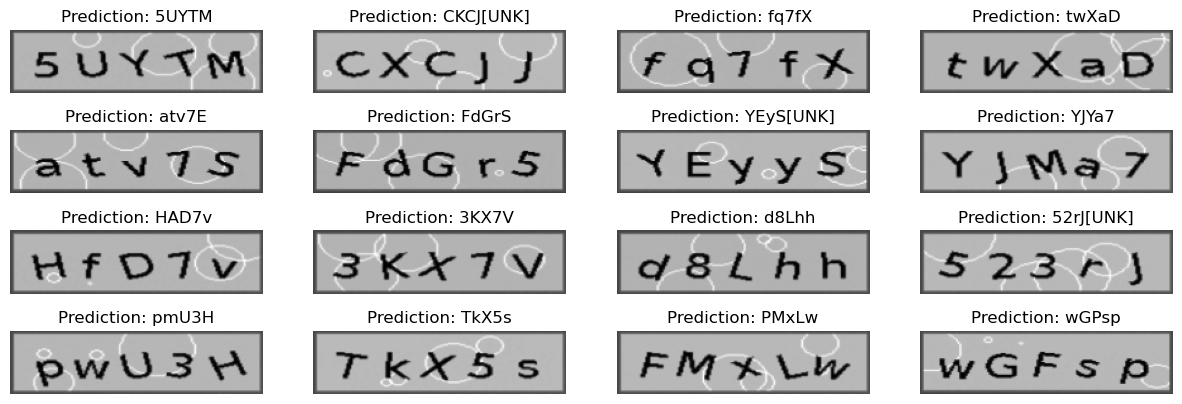

In [28]:
data2.make_predictions()

In [34]:
#data2.evaluate_precision_recall_f1()

In [31]:
total_images, correct_images, img_accuracy = data2.evaluate_image_prediction_accuracy()
print(f"Total images: {total_images}")
print(f"Correct predictions: {correct_images}")
print(f"Image Prediction Accuracy: {img_accuracy:.4f}")

1/1 [==============================] - 0s 21ms/step
Total images: 452
Correct predictions: 163
Image Prediction Accuracy: 0.3606


1/1 [==============================] - 0s 22ms/step


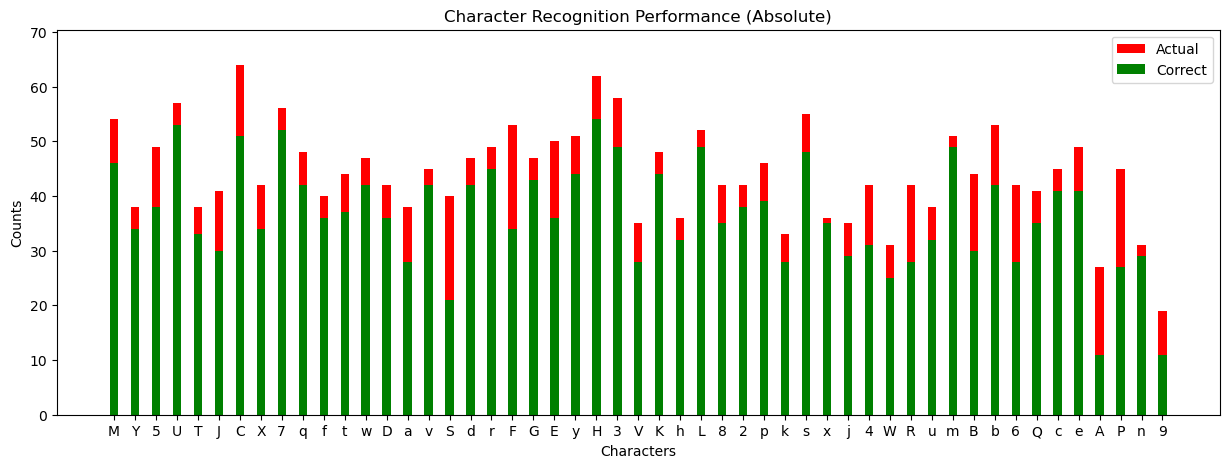

1/1 [==============================] - 0s 22ms/step


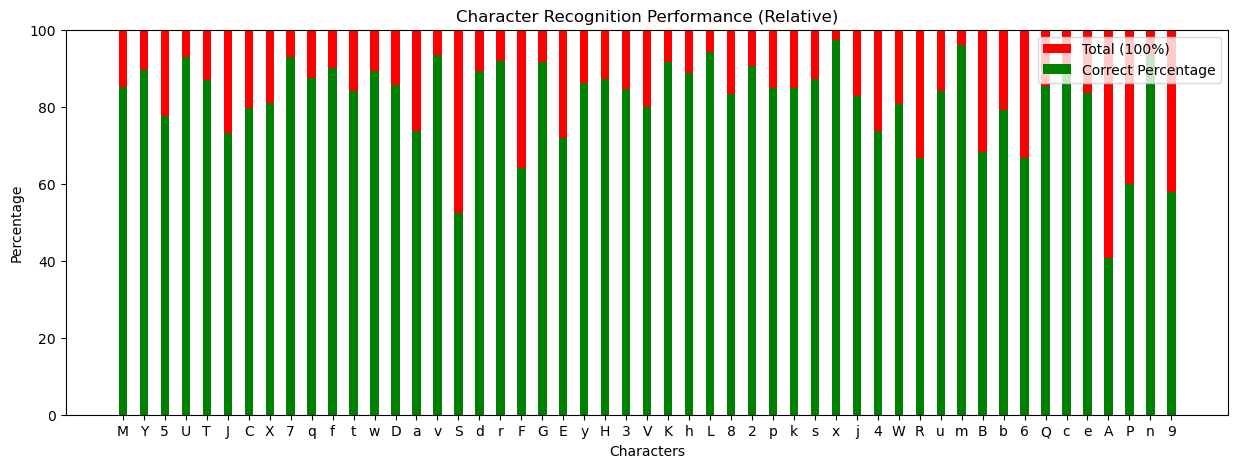

In [32]:
data2.plot_character_performance(plot_relative=False)
data2.plot_character_performance(plot_relative=True)

# Defining the second model which uses transfer learning

In [35]:
def second_model(self, base_model = None):
    # Inputs to the model
    input_img = layers.Input(
        shape=(self.img_width, self.img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
    base_model = keras.models.clone_model(base_model)
    base = keras.models.Model(
        base_model.get_layer(name="Conv1").input, base_model.get_layer(name="bidirectional1").output
        ,  name = "base_model"
    )
    # base.trainable = False
    x = base(input_img)
    # x = base(input_img, training = False)
    
    
    
     # Output layer
    x = layers.Dense(
        len(self.char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)
    
    
    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)
    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    self.model = model
    return model

# Using the base model trained with the first dataset

In [36]:
model2 = second_model(data2, base_model = loaded_base_model);
model2.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 base_model (Functional)     (None, 50, 256)              265664    ['image[0][0]']               
                                                                                                  
 label (InputLayer)          [(None, None)]               0         []                            
                                                                                                  
 dense2 (Dense)              (None, 50, 53)               13621     ['base_model[0][0]']          
                                                                                       

In [37]:
data2.train_model(epochs = d2_epochs, model = model2)

Epoch 1/100
132/132 [==============================] - 13s 79ms/step - loss: 23.7786 - val_loss: 21.5866
Epoch 2/100
132/132 [==============================] - 10s 77ms/step - loss: 21.3984 - val_loss: 21.5801
Epoch 3/100
132/132 [==============================] - 10s 77ms/step - loss: 21.3885 - val_loss: 21.4956
Epoch 4/100
132/132 [==============================] - 10s 77ms/step - loss: 21.3628 - val_loss: 21.5151
Epoch 5/100
132/132 [==============================] - 10s 77ms/step - loss: 20.6147 - val_loss: 17.6048
Epoch 6/100
132/132 [==============================] - 10s 77ms/step - loss: 10.6865 - val_loss: 3.4144
Epoch 7/100
132/132 [==============================] - 10s 78ms/step - loss: 3.2439 - val_loss: 1.0727
Epoch 8/100
132/132 [==============================] - 10s 77ms/step - loss: 1.4833 - val_loss: 0.4908
Epoch 9/100
132/132 [==============================] - 10s 76ms/step - loss: 0.8567 - val_loss: 0.2268
Epoch 10/100
132/132 [==============================] - 10s 75

132/132 [==============================] - 10s 73ms/step - loss: 0.0165 - val_loss: 4.3885e-04
Epoch 80/100
132/132 [==============================] - 10s 74ms/step - loss: 0.0108 - val_loss: 0.0523
Epoch 81/100
132/132 [==============================] - 10s 73ms/step - loss: 0.0497 - val_loss: 0.0013
Epoch 82/100
132/132 [==============================] - 10s 75ms/step - loss: 0.0168 - val_loss: 4.3207e-04
Epoch 83/100
132/132 [==============================] - 10s 75ms/step - loss: 0.0138 - val_loss: 4.0723e-04
Epoch 84/100
132/132 [==============================] - 10s 73ms/step - loss: 0.0226 - val_loss: 0.0025
Epoch 85/100
132/132 [==============================] - 10s 75ms/step - loss: 0.0210 - val_loss: 0.0904
Epoch 86/100
132/132 [==============================] - 10s 74ms/step - loss: 0.0378 - val_loss: 0.0034


## Making predictions

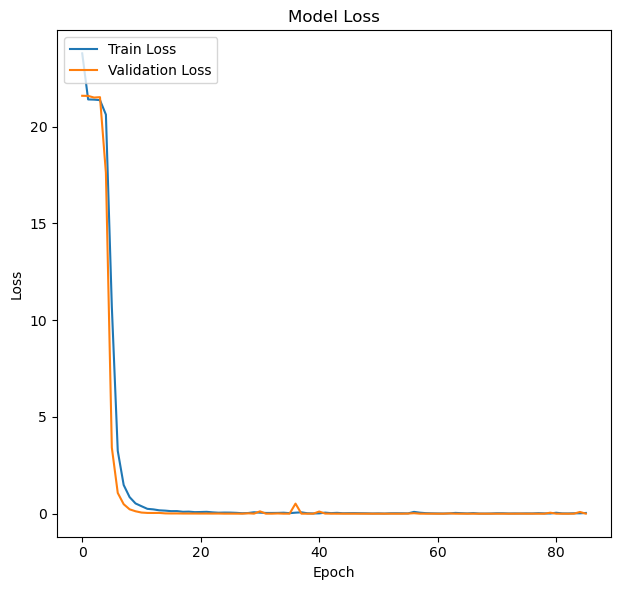

In [38]:
data2.plot_training_history()

1/1 [==============================] - 0s 435ms/step


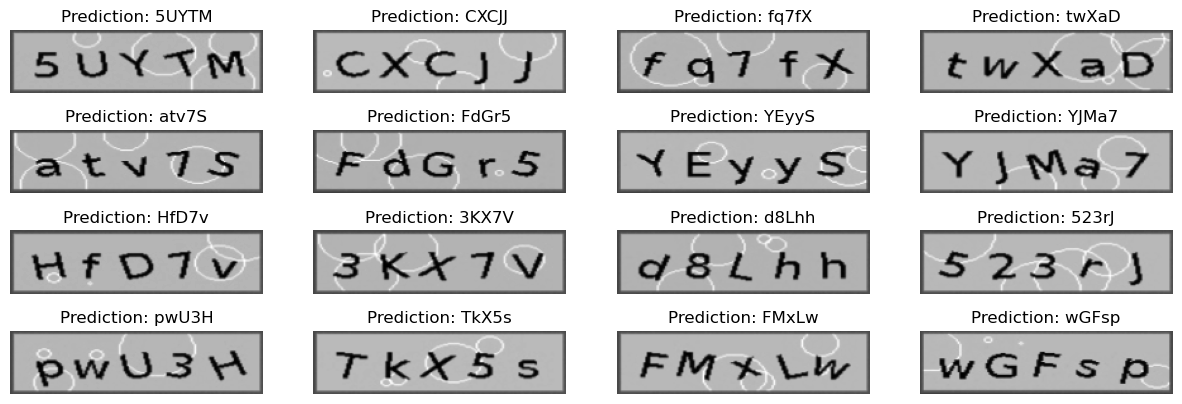

In [39]:
data2.make_predictions()

In [45]:
#data2.evaluate_precision_recall_f1()

In [46]:
total_images, correct_images, img_accuracy = data2.evaluate_image_prediction_accuracy()
print(f"Total images: {total_images}")
print(f"Correct predictions: {correct_images}")
print(f"Image Prediction Accuracy: {img_accuracy:.4f}")

1/1 [==============================] - 0s 20ms/step
Total images: 452
Correct predictions: 452
Image Prediction Accuracy: 1.0000


1/1 [==============================] - 0s 19ms/step


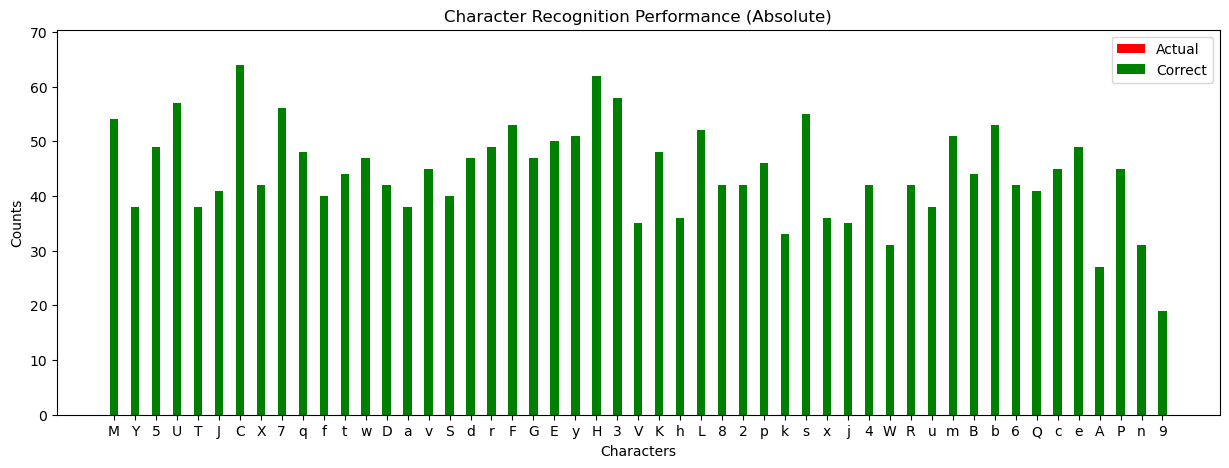

1/1 [==============================] - 0s 19ms/step


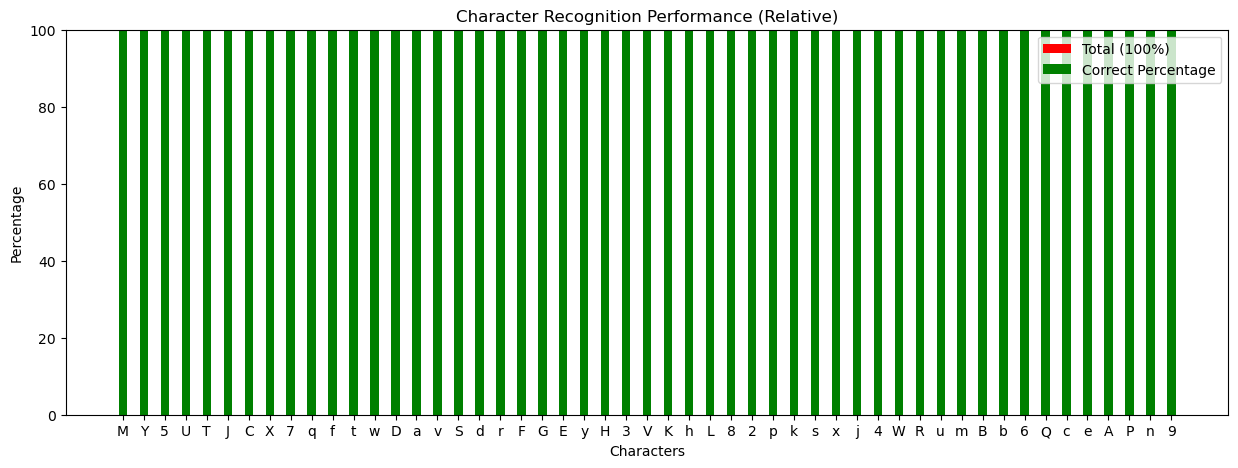

In [42]:
data2.plot_character_performance(plot_relative=False)
data2.plot_character_performance(plot_relative=True)

In [44]:
data2.count_characters_in_training()

Characters frequency in training:
'P' occurred 200 times
'H' occurred 207 times
'B' occurred 220 times
'E' occurred 225 times
'u' occurred 191 times
'V' occurred 203 times
'6' occurred 208 times
'h' occurred 217 times
'8' occurred 221 times
'x' occurred 208 times
'q' occurred 208 times
'c' occurred 206 times
'4' occurred 207 times
'F' occurred 200 times
'T' occurred 211 times
'e' occurred 230 times
'5' occurred 217 times
'w' occurred 184 times
'b' occurred 225 times
'r' occurred 233 times
'j' occurred 237 times
'2' occurred 228 times
'd' occurred 214 times
'f' occurred 198 times
'S' occurred 202 times
'3' occurred 221 times
'J' occurred 221 times
'Q' occurred 205 times
'D' occurred 179 times
'X' occurred 229 times
'p' occurred 195 times
'L' occurred 197 times
't' occurred 209 times
'A' occurred 100 times
's' occurred 242 times
'G' occurred 206 times
'U' occurred 198 times
'v' occurred 201 times
'K' occurred 197 times
'y' occurred 211 times
'C' occurred 200 times
'n' occurred 243 times


# Third dataset

In [ ]:
data3 = DataSetHandler(data_dir3, file_name_excluder="_1")
data3.split_data();
data3.process_dataset();
data3.plot_examples()
data3.print_basics()

In [ ]:
model3 = second_model(data3, loaded_base_model)

In [ ]:
data3.train_model(epochs = d3_epochs, model =  model3)

In [ ]:
data3.make_predictions()

In [ ]:
data3.make_predictions(data2.model)
